In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['bounding-boxes', 'model-weights', 'pic-to-hash', 'model-data', 'humpback-whale-identification']


In [2]:
bound_path = '../input/bounding-boxes'
data_path = '../input/humpback-whale-identification'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [3]:
# Read the dataset description
from pandas import read_csv

tagged = dict([(p,w) for _,p,w in read_csv('../input/humpback-whale-identification/train.csv').to_records()])
submit = [p for _,p,_ in read_csv('../input/humpback-whale-identification/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

(25361,
 7960,
 33321,
 [('0000e88ab.jpg', 'w_f48451c'),
  ('0001f9222.jpg', 'w_c3d896a'),
  ('00029d126.jpg', 'w_20df2c5'),
  ('00050a15a.jpg', 'new_whale'),
  ('0005c1ef8.jpg', 'new_whale')],
 ['00028a005.jpg',
  '000dcf7d8.jpg',
  '000e7c7df.jpg',
  '0019c34f4.jpg',
  '001a4d292.jpg'])

In [4]:
# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('../input/humpback-whale-identification/train/' + p): return '../input/humpback-whale-identification/train/' + p
    if isfile('../input/humpback-whale-identification/test/' + p): return '../input/humpback-whale-identification/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(33321,
 [('0000e88ab.jpg', (1050, 700)),
  ('0001f9222.jpg', (758, 325)),
  ('00029d126.jpg', (1050, 497)),
  ('00050a15a.jpg', (1050, 525)),
  ('0005c1ef8.jpg', (1050, 525))])

In [5]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('../input/pic-to-hash/p2h.pickle'):
    with open('../input/pic-to-hash/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h

len(p2h), list(p2h.items())[:5]

(33321,
 [('0000e88ab.jpg', 'd26698c3271c757c'),
  ('0001f9222.jpg', 'ba8cc231ad489b77'),
  ('00029d126.jpg', 'bbcad234a52d0f0b'),
  ('00050a15a.jpg', 'c09ae7dc09f33a29'),
  ('0005c1ef8.jpg', 'd02f65ba9f74a08a')])

In [ ]:
# Saving the result above
# import pickle

# with open('p2h.pickle', 'wb') as f: pickle.dump(p2h, f)

In [6]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)

len(h2ps),list(h2ps.items())[:5]

(33317,
 [('d26698c3271c757c', ['0000e88ab.jpg']),
  ('ba8cc231ad489b77', ['0001f9222.jpg']),
  ('bbcad234a52d0f0b', ['00029d126.jpg']),
  ('c09ae7dc09f33a29', ['00050a15a.jpg']),
  ('d02f65ba9f74a08a', ['0005c1ef8.jpg'])])

Images: ['01f66ca26.jpg', 'd37179fd1.jpg']
Images: ['579886448.jpg', 'f50529c53.jpg']
Images: ['60a3f2422.jpg', '7f7a63b8a.jpg']
Images: ['b95d73a55.jpg', 'fb3879dc7.jpg']


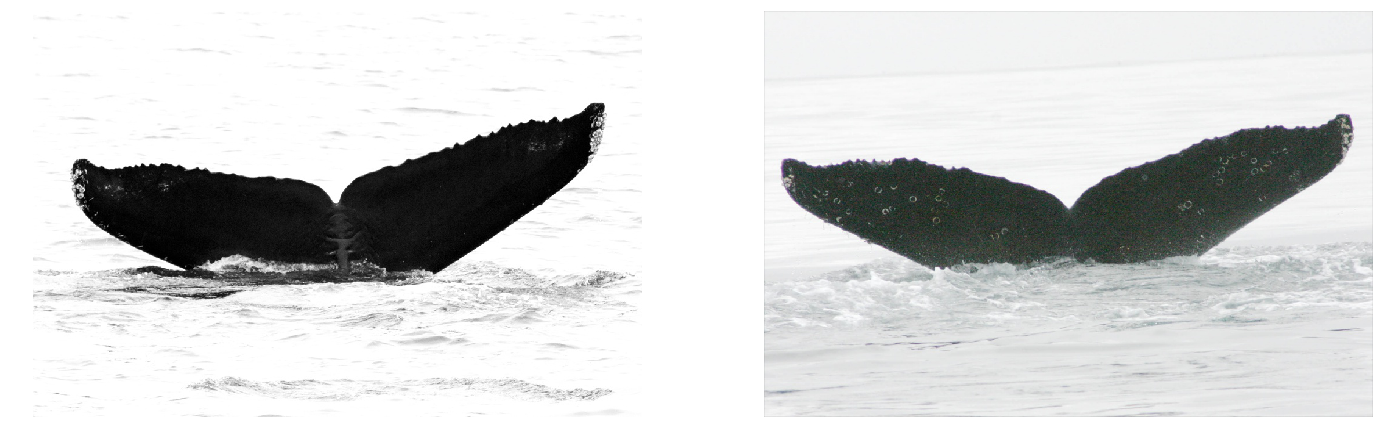

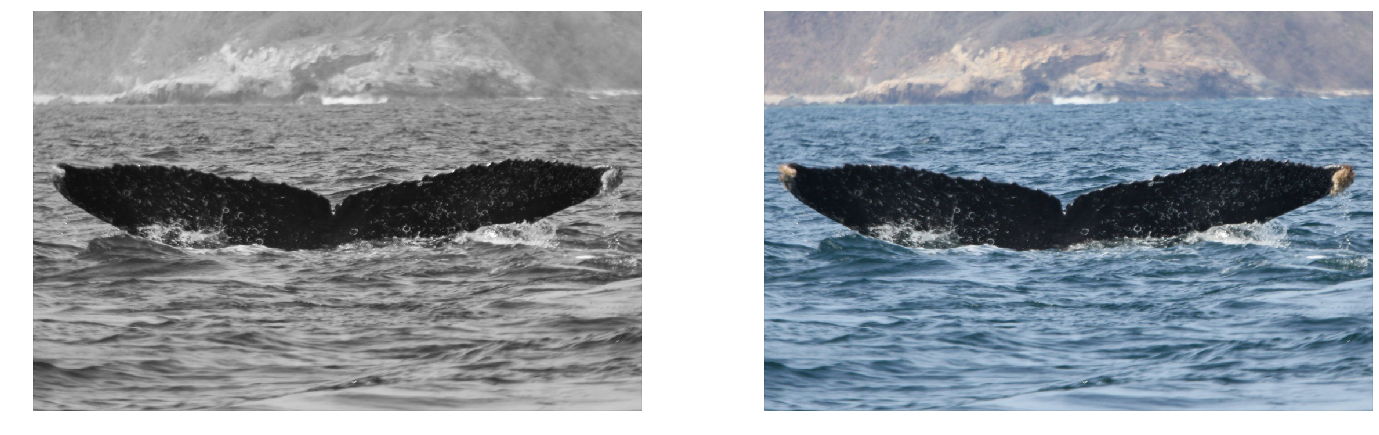

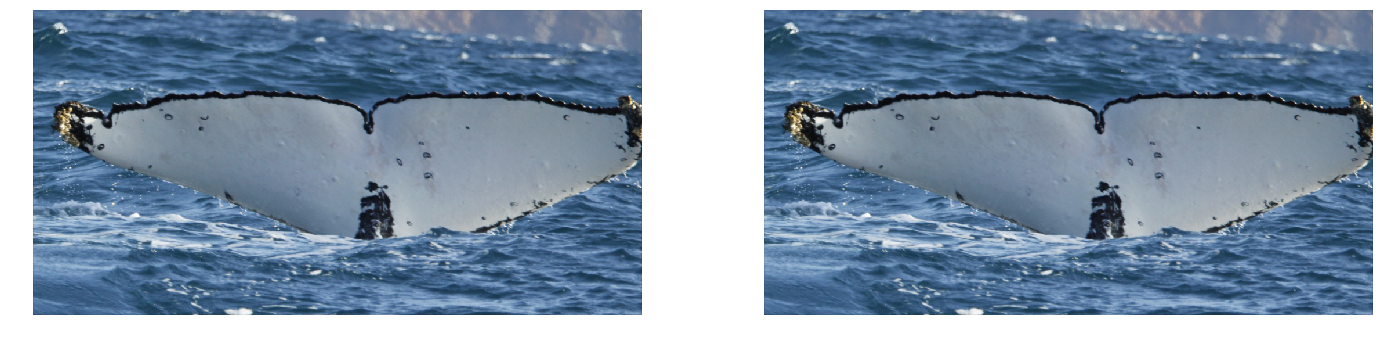

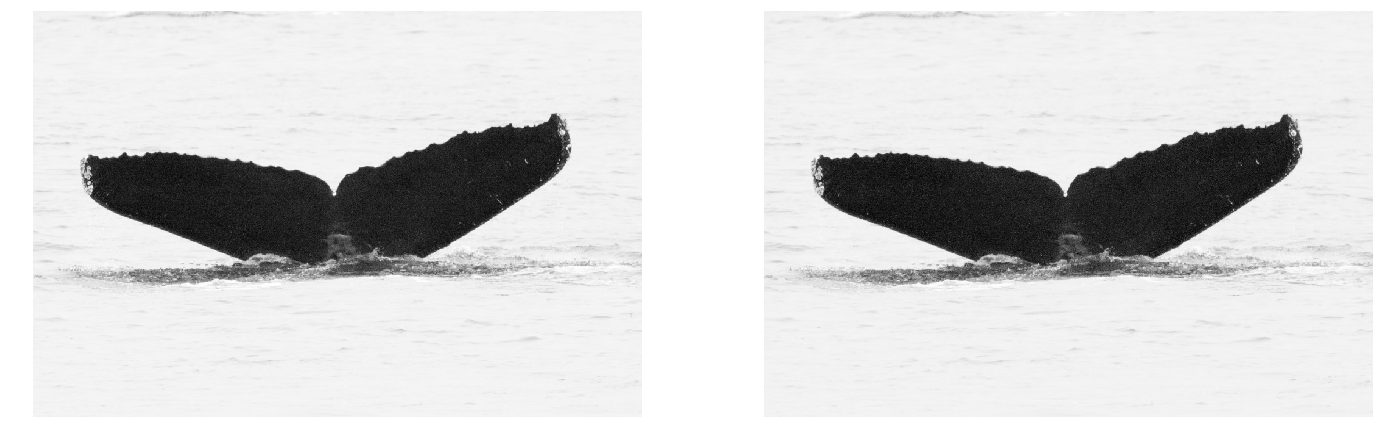

In [7]:
# Show an example of a duplicate image (from training of test set)
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

for h, ps in h2ps.items():
    if len(ps) > 1:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        

In [8]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

# Image Preprocessing

**Convert to black and white**


**Affine tranformation**

In [9]:
import csv
reader = csv.reader(open('../input/bounding-boxes/bounding_boxes.csv', 'r'))
p2bb = {}
for row in reader:
    k,a,b,c,d, = row
    if k == 'Image':
        continue
    else:
        p2bb[k] = (int(a),int(b),int(c),int(d))
# list(p2bb.items())[:5]

In [10]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1) # The image shape used by the model
anisotropy   = 2.15 # The horizontal compression ratio
crop_margin  = 0.05 # The margin added around the bounding box to compensate for bounding box inaccuracy

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
#     if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

In [11]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [12]:
p = list(tagged.keys())
# print(img_to_array(read_raw_image(p)).shape)
# print(read_for_validation(p).shape)

In [ ]:
# imgs = [
#     read_raw_image(p),
#     array_to_img(read_for_validation(p)),
#     array_to_img(read_for_training(p))
# ]
# show_whale(imgs, per_row=3)

### Triplet loss

In [14]:
import tensorflow as tf
def triplet_loss(y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
#     print(y_pred)
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    ### END CODE HERE ###
    
    return loss

### Model

In [15]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    input_shape = img_shape
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    anchor_embedding = branch_model(anchor_input)
    positive_embedding = branch_model(positive_input)
    negative_embedding = branch_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
#     merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)


    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(triplet_loss(outputs))
    
    triplet_model.compile(optim, loss=None)#, metrics=['binary_crossentropy', 'acc'])
    #model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return branch_model, triplet_model

branch_model, triplet_model = build_model(64e-5,0)


In [16]:
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 512)          2692096     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

### Plot the model

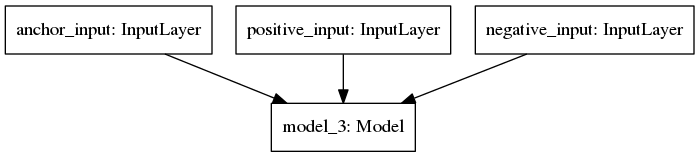

In [17]:
from keras.utils import plot_model
plot_model(triplet_model, to_file='triplet_model.png')
pil_image.open('triplet_model.png')


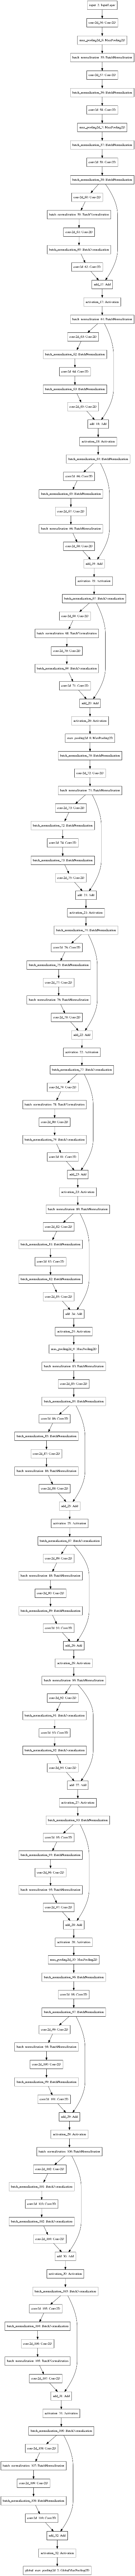

In [18]:
plot_model(branch_model, to_file='branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x//2 for x in img.size])

In [19]:
# Find all the whales associated with an image id. It can be ambiguous as duplicate images may have different whale ids.
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

15696

In [20]:
# For each whale, find the unambiguous images ids.
w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

5004

In [21]:
# Find the list of training images, keep only whales with at least two images.
train = [] # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)
len(train_set)

13623

In [22]:
w2ts = {} # Associate the image ids from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)


(13623, 2931)

In [23]:
!pip install lap

    100% |████████████████████████████████| 1.5MB 17.0MB/s ta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Training data generator
Linear Assignment Problem solver is used to create the matching and unmatching of whales for triplet loss

In [24]:
from keras.utils import Sequence

# First try to use lapjv Linear Assignment Problem solver as it is much faster.
# At the time I am writing this, kaggle kernel with custom package fail to commit.
# scipy can be used as a fallback, but it is too slow to run this kernel under the time limit
# As a workaround, use scipy with data partitioning.
# Because algorithm is O(n^3), small partitions are much faster, but not what produced the submitted solution
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment

class TrainingData(Sequence):
    def __init__(self, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        Shape of score: len(train_set) x len(train_set)
        """
        super(TrainingData, self).__init__()
        self.score = np.zeros((len(train), len(train)))
        self.steps      = steps
        self.batch_size = batch_size

        self.on_epoch_end()
    def __getitem__(self, index):
        """
        TrainingData instance[index] returns index-th batch
        eg:
        data = TrainingData(score)
        (a, b), c = data[0]
        in this case i <= 851
        
        """
        
        start = self.batch_size*index
        end   = min(start + self.batch_size, len(self.triplets))
        size  = end - start
        assert size > 0
        # (batch_size, 384,384,1)
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        # (batch_size, 384,384,1)
        b     = np.zeros((size,) + img_shape, dtype=K.floatx())
        # (batch_size, 384,384,1)
        c     = np.zeros((size,) + img_shape, dtype=K.floatx())
        j = start
        for i in range(0, size):
            a[i,  :,:,:] = read_for_training(self.triplets[j][0])
            b[i,  :,:,:] = read_for_training(self.triplets[j][1])
            c[i,  :,:,:] = read_for_training(self.triplets[j][2])
            j           += 1
    
        res = {
            'anchor_input': a,
            'positive_input': b,
            'negative_input': c
            }
        
        return (res, None)
    def on_epoch_end(self):
        """
        Creates complete list of matched, unmatched pairs
        """
        
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
#         self.match      = []
#         self.unmatch    = []
        self.triplets = []
        # Compute a derangement for matching whales
        loc_t2i = {}
        k = 0
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            
            ## consider doing this before defining class. one time only
            for a,b in zip(ts,d): 
                self.triplets.append((a,b))
                loc_t2i[a] = k
                k+=1
        z = 0
        for z in range(self.score.shape[0]):
            self.score[z,z] = 10000.0
            z+=1            
        for ts in w2ts.values():
            idxs = [loc_t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0                
        if segment:
            # Using slow scipy. Make small batches.
            # Because algorithm is O(n^3), small batches are much faster.
            # However, this does not find the real optimum, just an approximation.
            tmp   = []
            batch = 512
            for start in range(0, self.score.shape[0], batch):    #(0, 13623 (trainset_size), )
                end = min(self.score.shape[0], start + batch)        # (start,end) : (0,512) , (512, 1024) .... 
                """
                linear_sum_assignment -- creates pairs (derangement) by decreasing the cost, provided through score matrix
                Examples of usage:
                score = np.diag((5,6,7,8))
                score = np.array([[0,5,5,5], [5,0,5,5], [5,5,0,5], [5,5,5,0]])
                linear_sum_assignment(score)       
                """
                
                _, x = linear_sum_assignment(self.score[start:end, start:end])

                ## since we are using start:end slice of score, we are adding start to each number in the return matrix
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # Solve the linear assignment problem
            ## x = returns array of length(train_set) or score.shape[0]
        y = np.arange(len(x),dtype=np.int32)
        

        
        loc_i2t = {v: k for k, v in loc_t2i.items()}
        k = 0
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j

            temp = list(self.triplets[j]) + [loc_i2t[i]]
            
            self.triplets[j] = tuple(temp)

#         print(self.triplets[0], self.triplets[1], self.triplets[2])
        # Force a different choice for an eventual next epoch.
        #self.score[x,y] = 10000.0
        #self.score[y,x] = 10000.0
        #random.shuffle(self.match)
        #random.shuffle(self.unmatch)
#         print(len(self.triplets), len(train), len(self.triplets), len(train))
        assert len(self.triplets) == len(train) and len(self.triplets) == len(train)
    def __len__(self):
        return (len(self.triplets) + self.batch_size - 1)//self.batch_size

#### Demo of the generator

In [26]:
data = TrainingData()

In [27]:
anc_inp = data[0][0]['anchor_input']
pos_inp = data[0][0]['positive_input']
neg_inp = data[0][0]['negative_input']
anc_inp.shape, pos_inp.shape, neg_inp.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 384, 384, 1))

32 * 851 + 14 = 27, 246 

27, 246 / 2 = 13623 = size of the training set

i.e. every image was used in 2 positive and 2 negative samples for training

In [28]:
ind = 9

Anchor, Positive, and Negative example respectively

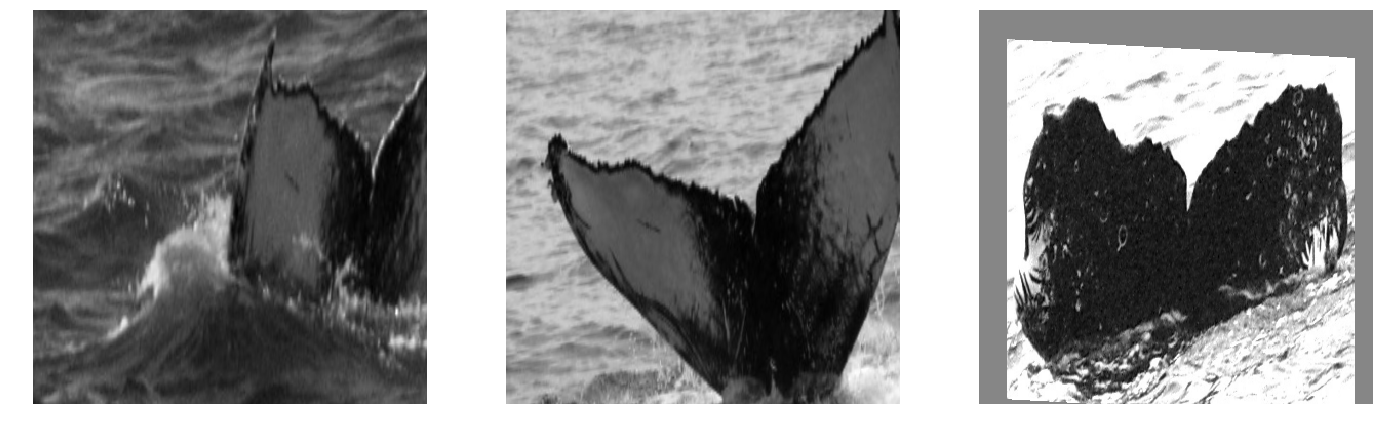

In [29]:
imgs = [array_to_img(anc_inp[ind]), array_to_img(pos_inp[ind]), array_to_img(neg_inp[ind])]
show_whale(imgs, per_row=3)

In [33]:
triplet_model.load_weights("../input/model-data/aorujov_wghts.h5")

### Function to change the model learning rate

In [ ]:
def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))
    
# set_lr(triplet_model, 0.1)

### Training

In [ ]:
history = triplet_model.fit_generator(
        TrainingData(steps=7, batch_size=32),
        initial_epoch=0, epochs=0 + 7, verbose=1).history

In [ ]:
# from keras.models import model_from_json

# # load json and create model
# json_file = open('../input/model-data/aorujov_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("../input/model-data/aorujov_wghts.h5")
# print("Loaded model from disk")

In [ ]:

# serialize model to JSON
# model_json = triplet_model.to_json()
# with open("aorujov_model.json", "w") as json_file:
#     json_file.write(model_json)
# serialize weights to HDF5
triplet_model.save_weights("aorujov_wghts.h5")
print("Saved model to disk")



In [ ]:
# triplet_model.weights
# loaded_model.weights
# triplet_model.get_weights()[0]
# loaded_model.get_weights()[0]
# triplet_model.load_weights("../input/model-data/aorujov_wghts.h5")
# branch_model.get_weights()[0]

In [34]:
from tqdm import tqdm_notebook
database = {}
for h in tqdm_notebook(train):
    mgi = read_for_validation(h)
    mgi = np.expand_dims(mgi, axis=0)
    pred = branch_model.predict(mgi)
    database[h] = pred

In [35]:
def find_min_five(test_emb):
    vals = [0.37, 100, 100, 100, 100]
    whls = ['new_whale', 'a', 'a', 'a', 'a']
    for h, train_emb in database.items():
        dist = np.linalg.norm(test_emb - train_emb)
        if dist > vals[4]:
            continue
        elif (dist > vals[3]) and (dist < vals[4]):
            vals[4] = dist
            whls[4] = h2ws[h][0]
        elif (dist > vals[2]) and (dist < vals[3]):
            vals[4] = vals[3]
            whls[4] = whls[3]
            vals[3] = dist
            whls[3] = h2ws[h][0]
        elif (dist > vals[1]) and (dist < vals[2]):
            vals[4] = vals[3]
            whls[4] = whls[3]
            vals[3] = vals[2]
            whls[3] = whls[2]
            vals[2] = dist
            whls[2] = h2ws[h][0]            
        elif (dist > vals[0]) and (dist < vals[1]):
            vals[4] = vals[3]
            whls[4] = whls[3]
            vals[3] = vals[2]
            whls[3] = whls[2]
            vals[2] = vals[1]
            whls[2] = whls[1]
            vals[1] = dist
            whls[1] = h2ws[h][0]
        elif (dist < vals[0]):
            vals[4] = vals[3]
            whls[4] = whls[3]
            vals[3] = vals[2]
            whls[3] = whls[2]
            vals[2] = vals[1]
            whls[2] = whls[1]
            vals[1] = vals[0]
            whls[1] = whls[0]            
            vals[0] = dist
            whls[0] = h2ws[h][0]
        else:
            print("smth strange is going on")
#     print(vals)
    return whls
                        
            
        
    

In [ ]:

test_closests = {}

for p in tqdm_notebook(submit):
    mgi = read_for_validation(p)
    mgi = np.expand_dims(mgi, axis=0)
    pred = branch_model.predict(mgi)
    l = find_min_five(pred)
    test_closests[p] = l
    


In [ ]:
result_df = pd.read_csv("../input/humpback-whale-identification/sample_submission.csv")
result_df.set_index("Image", inplace=True)
result_df.head()


In [ ]:
for row in result_df.iterrows():
    idx = row[0]
    tmp = test_closests[idx]
    result_df.loc[idx] = tmp[0] + " " + tmp[1] + " " + tmp[2] + " " + tmp[3] + " " + tmp[4]

In [ ]:
result_df

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


# create a link to download the dataframe
create_download_link(result_df)